In [50]:
# %pip install python-dotenv grandalf


In [51]:
# %# 필요한 langchain 패키지들 설치
# %pip install langchain langchain-core langchain-experimental langchain-community langchain-openai langchain-teddynote langchain-huggingface langchain-google-genai langchain-anthropic langchain-cohere langchain-chroma langchain-elasticsearch langchain-upstage langchain-milvus langchain-text-splitters python-dotenv

In [52]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from os import environ
from dotenv import load_dotenv

from langchain_core.load import load, loads
from langchain_teddynote import logging

# API KEY 정보로드
load_dotenv()
logging.langsmith("week4-deep")

# import os

# print(f"[API KEY]\n{os.environ['OPENAI_API_KEY'][:-30]}" + "*" * 30)

LangSmith 추적을 시작합니다.
[프로젝트명]
week4-deep


# 샘플
https://github.com/NomaDamas/KICE_slayer_AI_Korean


In [53]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
system_prompt = """
한국어 시험 문제 분석 전문가로서, 요구된 분석과 정답만을 간결하게 제공하세요. 
불필요한 설명은 배제하고 문제의 핵심만 파악하여 정확한 답변과 간략한 근거만 출력하세요.
모든 응답은 목적에 부합하는 내용만 포함해야 합니다.
"""

llm = ChatOpenAI(
    model_name="gpt-4.1-mini",
    temperature=0,
)

def invoke_with_system_message(prompt):
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=prompt)
    ]
    return llm.invoke(messages)

In [54]:
from typing import Dict, List, Any, TypedDict, Literal, Optional, Union
from langgraph.graph import StateGraph, START, END

from langchain.prompts import PromptTemplate, ChatPromptTemplate


import json
import re


# 상태 타입 정의
class KoreanExamState(TypedDict):
    number: Optional[int]  # 문제 번호
    paragraph: str  # 지문
    question_plus: Optional[str]  # 추가 설명
    question: str  # 문제
    choices: List[str]  # 선택지 배열
    # answer: Optional[int]  # 정답 번호 (평가용)
    # score: Optional[int]  # 점수 (평가용)

    problem_type: Optional[str]
    context_analysis: Optional[str]
    question_analysis: Optional[str]
    option_evaluations: Optional[List[Dict[str, Any]]]
    explanation: Optional[str]
    review_notes: Optional[str]
    needs_revision: Optional[bool]
    revision_target: Optional[str]
    revised_analysis: Optional[Dict[str, Any]]
    final_response: Optional[str]
    structured_answer: Optional[int]
    # correct: Optional[bool]  # 정답 여부 (평가용)


# 1. 문제 유형 분류
def classify_problem(state: KoreanExamState) -> KoreanExamState:
    # 선택지 문자열 변환
    choices_text = "\n".join(
        [f"{i+1}. {choice}" for i, choice in enumerate(state["choices"])]
    )

    prompt = PromptTemplate.from_template(
        """다음 국어 문제가 어떤 유형인지 분류해주세요:
        1. 문학 (소설, 시, 희곡, 수필 등)
        2. 비문학 (인문, 사회, 과학, 기술 등)
        3. 문법
        4. 화법과 작문
        
        지문: {paragraph}
        추가 설명: {question_plus}
        문제: {question}
        선택지: {choices}
        
        답변 형식: "유형: [번호]"
        """
    )

    result = invoke_with_system_message(
        
        
            prompt.format(
                paragraph=state["paragraph"] if state["paragraph"] else "",
                question_plus=(
                    state["question_plus"] if state.get("question_plus") else ""
                ),
                question=state["question"],
                choices=choices_text,
            ),
        
    )

    problem_type = result.content.strip().split(":")[1].strip()
    return {**state, "problem_type": problem_type}


# 2. 지문 분석
def analyze_context(state: KoreanExamState) -> KoreanExamState:
    # 문제 유형에 따른 프롬프트 선택
    if state["problem_type"] == "1":  # 문학
        prompt_template = """다음 문학 작품 지문을 분석해주세요:
        1. 장르 (소설, 시, 희곡, 수필 등)
        2. 주제
        3. 서술 방식/문체
        4. 주요 인물 또는 화자의 특성
        5. 주요 상징이나 이미지
        6. 작품의 분위기나 정서
        
        지문: {paragraph}
        {question_plus_text}
        
        상세하게 분석해주세요.
        """
    elif state["problem_type"] == "2":  # 비문학
        prompt_template = """다음 비문학 지문을 분석해주세요:
        1. 글의 종류 (인문, 사회, 과학, 기술 등)
        2. 주제
        3. 논지 전개 방식
        4. 주요 논점들
        5. 필자의 관점
        6. 핵심 개념이나 이론
        
        지문: {paragraph}
        {question_plus_text}
        
        단락별 요약과 함께 상세하게 분석해주세요.
        """
    elif state["problem_type"] == "3":  # 문법
        # 문법 문제는 지문 분석이 필요 없는 경우가 많음
        return {
            **state,
            "context_analysis": "문법 문제는 지문 분석이 필요 없거나 제한적입니다.",
        }
    elif state["problem_type"] == "4":  # 화법과 작문
        prompt_template = """다음 화법/작문 관련 지문을 분석해주세요:
        1. 상황 맥락 (대화, 연설, 글쓰기 등)
        2. 화자/필자의 의도
        3. 사용된 주요 화법/작문 전략
        4. 중심 내용
        
        지문: {paragraph}
        {question_plus_text}
        
        의사소통 관점에서 상세하게 분석해주세요.
        """
    else:
        prompt_template = """다음 지문을 분석해주세요:
        1. 글의 종류
        2. 주제
        3. 주요 내용
        4. 서술 방식
        
        지문: {paragraph}
        {question_plus_text}
        
        상세하게 분석해주세요.
        """

    prompt = PromptTemplate.from_template(prompt_template)

    # 지문이 없는 경우 처리
    if not state["paragraph"] or state["paragraph"].strip() == "":
        return {**state, "context_analysis": "지문이 제공되지 않았습니다."}

    # 추가 설명이 있는 경우 포함
    question_plus_text = (
        f"추가 설명: {state['question_plus']}" if state.get("question_plus") else ""
    )

    result = invoke_with_system_message(
        prompt.format(
            paragraph=state["paragraph"], question_plus_text=question_plus_text
        )
    )

    return {**state, "context_analysis": result.content}


# 3. 문제 분석
def analyze_question(state: KoreanExamState) -> KoreanExamState:
    prompt = PromptTemplate.from_template(
        """다음 국어 문제를 분석해주세요:
        1. 문제가 요구하는 것이 무엇인지
        2. 문제 해결에 필요한 핵심 개념이나 접근 방법
        3. 문제의 난이도
        
        {question_plus_text}
        문제: {question}
        
        상세하게 분석해주세요.
        """
    )

    # 추가 설명이 있는 경우 포함
    question_plus_text = (
        f"추가 설명: {state['question_plus']}" if state.get("question_plus") else ""
    )

    result = invoke_with_system_message(
        prompt.format(question=state["question"], question_plus_text=question_plus_text)
    )

    return {**state, "question_analysis": result.content}


# 4. 선택지 평가
def evaluate_options(state: KoreanExamState) -> KoreanExamState:
    # 선택지 문자열 변환
    choices_text = "\n".join(
        [f"{i+1}. {choice}" for i, choice in enumerate(state["choices"])]
    )

    prompt_template = """
    다음 국어 문제의 각 선택지를 평가해주세요.
    
    지문: {paragraph}
    {question_plus_text}
    문제: {question}
    선택지: 
    {choices}
    
    지문 분석: {context_analysis}
    문제 분석: {question_analysis}
    
    각 선택지를 개별적으로 평가하고, 각각이 정답인지 아닌지 판단해주세요.
    평가 결과를 다음 JSON 형식으로 제공해주세요:
    ```json
    [
        {{"option": 1, "text": "선택지 내용", "evaluation": "평가 내용", "is_correct": true/false}},
        {{"option": 2, "text": "선택지 내용", "evaluation": "평가 내용", "is_correct": true/false}},
        ...
    ]
    ```
    
    """

    prompt = PromptTemplate.from_template(prompt_template)

    # 추가 설명이 있는 경우 포함
    question_plus_text = (
        f"추가 설명: {state['question_plus']}" if state.get("question_plus") else ""
    )

    result = invoke_with_system_message(
        prompt.format(
            paragraph=state["paragraph"],
            question_plus_text=question_plus_text,
            question=state["question"],
            choices=choices_text,
            context_analysis=state["context_analysis"],
            question_analysis=state["question_analysis"],
        )
    )

    # JSON 추출
    json_str = result.content
    if "```json" in json_str:
        json_str = json_str.split("```json")[1].split("```")[0]
    elif "```" in json_str:
        json_str = json_str.split("```")[1].split("```")[0]

    try:
        option_evaluations = json.loads(json_str)
        # 선택지 번호가 문자열인 경우 정수로 변환
        for option in option_evaluations:
            if "option" in option and isinstance(option["option"], str):
                try:
                    option["option"] = int(option["option"])
                except:
                    pass
    except:
        # JSON 파싱 실패 시 기본 형식 생성
        option_evaluations = []
        for i, choice in enumerate(state["choices"]):
            option_evaluations.append(
                {
                    "option": i + 1,
                    "text": choice,
                    "evaluation": "평가 실패",
                    "is_correct": False,
                }
            )

    return {**state, "option_evaluations": option_evaluations}


# 5. 답안 도출
def determine_answer(state: KoreanExamState) -> KoreanExamState:
    # 옵션 평가에서 정답 찾기
    structured_answer = None
    for option in state["option_evaluations"]:
        if "is_correct" in option and option["is_correct"]:
            structured_answer = option["option"]
            break

    if not structured_answer:
        # 정답을 명확히 찾지 못한 경우, 다시 분석
        # 선택지 문자열 변환
        choices_text = "\n".join(
            [f"{i+1}. {choice}" for i, choice in enumerate(state["choices"])]
        )

        prompt = PromptTemplate.from_template(
            """다음 국어 문제와 분석 결과를 바탕으로 최종 답안을 선택해주세요:
            
            지문: {paragraph}
            {question_plus_text}
            문제: {question}
            선택지: 
            {choices}
            
            지문 분석: {context_analysis}
            문제 분석: {question_analysis}
            선택지 평가: {option_evaluations}
            
            최종 답안 번호(1, 2, 3, 4, 5 중 하나)만 제시해주세요.
            """
        )

        # 추가 설명이 있는 경우 포함
        question_plus_text = (
            f"추가 설명: {state['question_plus']}" if state.get("question_plus") else ""
        )

        result = invoke_with_system_message(
            prompt.format(
                paragraph=state["paragraph"],
                question_plus_text=question_plus_text,
                question=state["question"],
                choices=choices_text,
                context_analysis=state["context_analysis"],
                question_analysis=state["question_analysis"],
                option_evaluations=str(state["option_evaluations"]),
            )
        )

        answer_text = result.content.strip()
        # 숫자 추출
        numbers = re.findall(r"\d+", answer_text)
        if numbers:
            structured_answer = int(numbers[0])
        else:
            # 답을 찾지 못한 경우 기본값 설정
            structured_answer = 1

    # 정답 번호가 문자열인 경우 정수로 변환
    if isinstance(structured_answer, str):
        try:
            structured_answer = int(structured_answer)
        except:
            structured_answer = 1

    # 정답 여부 확인 (평가용)
    correct = (
        state.get("answer") == structured_answer
        if state.get("answer") is not None
        else None
    )

    return {**state, "structured_answer": structured_answer, "correct": correct}


# 6. 답안 설명
def explain_answer(state: KoreanExamState) -> KoreanExamState:
    # 선택지 문자열 변환
    choices_text = "\n".join(
        [f"{i+1}. {choice}" for i, choice in enumerate(state["choices"])]
    )

    prompt = PromptTemplate.from_template(
        """다음 국어 문제에 대한 최종 답안을 설명해주세요:
        
        지문: {paragraph}
        {question_plus_text}
        문제: {question}
        선택지: 
        {choices}
        
        선택한 답안: {answer}번
        
        다음을 포함하여 설명해주세요:
        1. 왜 그 답안이 정답인지에 대한 상세한 설명
        2. 다른 선택지들이 왜 오답인지에 대한 설명
        3. 지문에서 정답을 뒷받침하는 구체적인 근거
        
        명확하고 논리적으로 설명해주세요.
        """
    )

    # 추가 설명이 있는 경우 포함
    question_plus_text = (
        f"추가 설명: {state['question_plus']}" if state.get("question_plus") else ""
    )

    result = invoke_with_system_message(
        prompt.format(
            paragraph=state["paragraph"],
            question_plus_text=question_plus_text,
            question=state["question"],
            choices=choices_text,
            answer=state["structured_answer"],
        )
    )

    return {**state, "explanation": result.content}


# 7. 검토 과정 - 모든 분석과 추론을 검토
def review_analysis(state: KoreanExamState) -> KoreanExamState:
    # 선택지 문자열 변환
    choices_text = "\n".join(
        [f"{i+1}. {choice}" for i, choice in enumerate(state["choices"])]
    )

    prompt = PromptTemplate.from_template(
        """국어 문제 풀이 과정을 철저히 검토해주세요. 다음 각 분석 단계에서 오류나 개선할 점이 있는지 평가하세요:
        
        지문: {paragraph}
        {question_plus_text}
        문제: {question}
        선택지: 
        {choices}
        
        지문 분석: {context_analysis}
        문제 분석: {question_analysis}
        선택지 평가: {option_evaluations}
        도출된 답안: {answer}번
        답안 설명: {explanation}
        
        다음 항목들을 중점적으로 검토하세요:
        1. 지문에 대한 이해가 정확한가?
        2. 문제의 요구사항을 제대로 파악했는가?
        3. 선택지 평가가 논리적이고 일관성이 있는가?
        4. 답안 선택의 근거가 충분한가?
        5. 지문의 맥락과 문제의 의도를 제대로 반영했는가?
        
        검토 결과를 다음 형식으로 제공해주세요:
        ```json
        {{
            "needs_revision": true/false,
            "revision_target": "context_analysis/question_analysis/option_evaluations/answer/explanation",
            "review_notes": "검토 내용과 개선 제안"
        }}
        ```
        
        철저하고 비판적인 시각으로 검토해주세요.
        """
    )

    # 추가 설명이 있는 경우 포함
    question_plus_text = (
        f"추가 설명: {state['question_plus']}" if state.get("question_plus") else ""
    )

    result = invoke_with_system_message(
        prompt.format(
            paragraph=state["paragraph"],
            question_plus_text=question_plus_text,
            question=state["question"],
            choices=choices_text,
            context_analysis=state["context_analysis"],
            question_analysis=state["question_analysis"],
            option_evaluations=str(state["option_evaluations"]),
            answer=state["structured_answer"],
            explanation=state["explanation"],
        )
    )

    # JSON 추출
    json_str = result.content
    if "```json" in json_str:
        json_str = json_str.split("```json")[1].split("```")[0]
    elif "```" in json_str:
        json_str = json_str.split("```")[1].split("```")[0]

    try:
        review_result = json.loads(json_str)
        return {
            **state,
            "review_notes": review_result.get("review_notes", "검토 완료"),
            "needs_revision": review_result.get("needs_revision", False),
            "revision_target": review_result.get("revision_target", None),
        }
    except:
        # JSON 파싱 실패 시 기본값 설정
        return {
            **state,
            "review_notes": "검토 결과 파싱 실패: " + result.content,
            "needs_revision": False,
            "revision_target": None,
        }


# 8. 분석 수정 - 검토 결과에 따른 수정 작업
def revise_analysis(state: KoreanExamState) -> KoreanExamState:
    target = state["revision_target"]
    review_notes = state["review_notes"]

    # 선택지 문자열 변환
    choices_text = "\n".join(
        [f"{i+1}. {choice}" for i, choice in enumerate(state["choices"])]
    )

    # 추가 설명이 있는 경우 포함
    question_plus_text = (
        f"추가 설명: {state['question_plus']}" if state.get("question_plus") else ""
    )

    if target == "context_analysis":
        prompt_template = """
        국어 지문 분석을 다시 수행해주세요. 이전 분석에서 다음과 같은 문제점이 발견되었습니다:
        
        문제점: {review_notes}
        
        지문: {paragraph}
        {question_plus_text}
        
        이전 분석: {context_analysis}
        
        위 문제점을 해결하여 더 정확하고 심층적인 지문 분석을 제공해주세요.
        """

        prompt = PromptTemplate.from_template(prompt_template)
        result = invoke_with_system_message(
            prompt.format(
                review_notes=review_notes,
                paragraph=state["paragraph"],
                question_plus_text=question_plus_text,
                context_analysis=state["context_analysis"],
            )
        )

        return {**state, "revised_analysis": {"context_analysis": result.content}}

    elif target == "question_analysis":
        prompt_template = """
        국어 문제 분석을 다시 수행해주세요. 이전 분석에서 다음과 같은 문제점이 발견되었습니다:
        
        문제점: {review_notes}
        
        {question_plus_text}
        문제: {question}
        
        이전 분석: {question_analysis}
        
        위 문제점을 해결하여 더 정확하고 심층적인 문제 분석을 제공해주세요.
        """

        prompt = PromptTemplate.from_template(prompt_template)
        result = invoke_with_system_message(
            prompt.format(
                review_notes=review_notes,
                question_plus_text=question_plus_text,
                question=state["question"],
                question_analysis=state["question_analysis"],
            )
        )

        return {**state, "revised_analysis": {"question_analysis": result.content}}

    elif target == "option_evaluations":
        prompt_template = """
        국어 선택지 평가를 다시 수행해주세요. 이전 평가에서 다음과 같은 문제점이 발견되었습니다:
        
        문제점: {review_notes}
        
        지문: {paragraph}
        {question_plus_text}
        문제: {question}
        선택지: 
        {choices}
        
        이전 평가: {option_evaluations}
        
        위 문제점을 해결하여 더 정확하고 논리적인 선택지 평가를 제공해주세요.
        평가 결과를 다음 JSON 형식으로 제공해주세요:
        ```json
        [
            {{"option": 1, "text": "선택지 내용", "evaluation": "평가 내용", "is_correct": true/false}},
            {{"option": 2, "text": "선택지 내용", "evaluation": "평가 내용", "is_correct": true/false}},
            ...
        ]
        ```
        """

        prompt = PromptTemplate.from_template(prompt_template)
        result = invoke_with_system_message(
            prompt.format(
                review_notes=review_notes,
                paragraph=state["paragraph"],
                question_plus_text=question_plus_text,
                question=state["question"],
                choices=choices_text,
                option_evaluations=str(state["option_evaluations"]),
            )
        )

        # JSON 추출
        json_str = result.content
        if "```json" in json_str:
            json_str = json_str.split("```json")[1].split("```")[0]
        elif "```" in json_str:
            json_str = json_str.split("```")[1].split("```")[0]

        try:
            revised_evaluations = json.loads(json_str)
            # 선택지 번호가 문자열인 경우 정수로 변환
            for option in revised_evaluations:
                if "option" in option and isinstance(option["option"], str):
                    try:
                        option["option"] = int(option["option"])
                    except:
                        pass
            return {
                **state,
                "revised_analysis": {"option_evaluations": revised_evaluations},
            }
        except:
            return {
                **state,
                "revised_analysis": {
                    "option_evaluations": "JSON 파싱 실패: " + result.content
                },
            }

    elif target == "answer":
        prompt_template = """
        국어 문제의 답안을 다시 검토해주세요. 이전 답안 선택에서 다음과 같은 문제점이 발견되었습니다:
        
        문제점: {review_notes}
        
        지문: {paragraph}
        {question_plus_text}
        문제: {question}
        선택지: 
        {choices}
        
        지문 분석: {context_analysis}
        문제 분석: {question_analysis}
        선택지 평가: {option_evaluations}
        
        이전 답안: {answer}번
        
        위 문제점을 해결하여 더 정확한 답안 번호(1, 2, 3, 4, 5 중 하나)를 선택해주세요.
        """

        prompt = PromptTemplate.from_template(prompt_template)
        result = invoke_with_system_message(
            prompt.format(
                review_notes=review_notes,
                paragraph=state["paragraph"],
                question_plus_text=question_plus_text,
                question=state["question"],
                choices=choices_text,
                context_analysis=state["context_analysis"],
                question_analysis=state["question_analysis"],
                option_evaluations=str(state["option_evaluations"]),
                answer=state["structured_answer"],
            )
        )

        answer_text = result.content.strip()
        # 숫자 추출
        numbers = re.findall(r"\d+", answer_text)
        revised_answer = int(numbers[0]) if numbers else state["structured_answer"]

        return {**state, "revised_analysis": {"answer": revised_answer}}

    elif target == "explanation":
        prompt_template = """
        국어 문제의 답안 설명을 다시 작성해주세요. 이전 설명에서 다음과 같은 문제점이 발견되었습니다:
        
        문제점: {review_notes}
        
        지문: {paragraph}
        {question_plus_text}
        문제: {question}
        선택지: 
        {choices}
        답안: {answer}번
        
        이전 설명: {explanation}
        
        위 문제점을 해결하여 더 명확하고 논리적인 답안 설명을 제공해주세요.
        """

        prompt = PromptTemplate.from_template(prompt_template)
        result = invoke_with_system_message(
            prompt.format(
                review_notes=review_notes,
                paragraph=state["paragraph"],
                question_plus_text=question_plus_text,
                question=state["question"],
                choices=choices_text,
                answer=state["structured_answer"],
                explanation=state["explanation"],
            )
        )

        return {**state, "revised_analysis": {"explanation": result.content}}

    else:
        # 수정 대상이 명확하지 않은 경우
        return {**state, "revised_analysis": {"note": "수정 대상이 명확하지 않습니다."}}


# 9. 수정사항 적용
def apply_revisions(state: KoreanExamState) -> KoreanExamState:
    revised = state.get("revised_analysis", {})

    updated_state = {**state}

    # 각 수정사항을 적용
    if "context_analysis" in revised:
        updated_state["context_analysis"] = revised["context_analysis"]

    if "question_analysis" in revised:
        updated_state["question_analysis"] = revised["question_analysis"]

    if "option_evaluations" in revised:
        if isinstance(revised["option_evaluations"], list):
            updated_state["option_evaluations"] = revised["option_evaluations"]
        else:
            # JSON 파싱 실패한 경우 원본 유지
            pass

    if "answer" in revised:
        updated_state["structured_answer"] = revised["answer"]
        # 정답 여부 재확인
        updated_state["correct"] = (
            state.get("answer") == revised["answer"]
            if state.get("answer") is not None
            else None
        )

    if "explanation" in revised:
        updated_state["explanation"] = revised["explanation"]

    # 수정 후 재검토 필요 여부 초기화
    updated_state["needs_revision"] = False
    updated_state["revision_target"] = None

    return updated_state


# 10. 최종 응답 생성
def generate_final_response(state: KoreanExamState) -> KoreanExamState:
    # 옵션 평가 문자열 생성
    option_evaluations_str = ""
    for option in state.get("option_evaluations", []):
        if (
            isinstance(option, dict)
            and "option" in option
            and "evaluation" in option
            and "text" in option
        ):
            option_evaluations_str += f"- 선택지 {option['option']}: {option['text']}\n  평가: {option['evaluation']}\n"

    # 최종 응답 생성
    final_response = f"""
    # 국어 문제 분석 결과 (문제 {state.get('number', '번호 없음')})
    
    ## 문제 유형
    {state.get("problem_type", "유형 분류 실패")}
    
    ## 문제 분석
    {state.get("question_analysis", "문제 분석 실패")}
    
    ## 지문 분석
    {state.get("context_analysis", "지문 분석 실패")}
    
    ## 선택지 평가
    {option_evaluations_str if option_evaluations_str else "선택지 평가 실패"}
    
    ## 검토 내용
    {state.get("review_notes", "검토 완료")}
    
    ## 최종 답안
    {state.get("structured_answer", "답안 도출 실패")}번
    
    ## 답안 설명
    {state.get("explanation", "설명 생성 실패")}
    
    """

    return {**state, "final_response": final_response}


# 라우터 함수 - 다음 단계 결정
def router(state: KoreanExamState) -> Dict[str, Any]:
    # 검토 과정 처리
    if (
        state.get("needs_revision") == True
        and state.get("revision_target")
        and not state.get("revised_analysis")
    ):
        return {"next": "revise_analysis"}
    elif state.get("revised_analysis") and state.get("needs_revision") == True:
        return {"next": "apply_revisions"}

    # 문법 문제는 지문 분석 단계를 건너뛸 수 있음
    elif state.get("problem_type") == "3" and not state.get("question_analysis"):
        return {"next": "analyze_question"}

    # 기본 플로우
    elif not state.get("context_analysis"):
        return {"next": "analyze_context"}
    elif not state.get("question_analysis"):
        return {"next": "analyze_question"}
    elif not state.get("option_evaluations"):
        return {"next": "evaluate_options"}
    elif not state.get("structured_answer"):
        return {"next": "determine_answer"}
    elif not state.get("explanation"):
        return {"next": "explain_answer"}
    elif not state.get("review_notes"):
        return {"next": "review_analysis"}
    elif not state.get("final_response"):
        return {"next": "generate_final_response"}
    else:
        return {"next": END}


# 그래프 구성
# 그래프 구성
def create_workflow():
    workflow = StateGraph(KoreanExamState)

    # 노드 추가
    workflow.add_node("classify_problem", classify_problem)
    workflow.add_node("analyze_context", analyze_context)
    workflow.add_node("analyze_question", analyze_question)
    workflow.add_node("evaluate_options", evaluate_options)
    workflow.add_node("determine_answer", determine_answer)
    workflow.add_node("explain_answer", explain_answer)
    workflow.add_node("review_analysis", review_analysis)
    workflow.add_node("revise_analysis", revise_analysis)
    workflow.add_node("apply_revisions", apply_revisions)
    workflow.add_node("generate_final_response", generate_final_response)
    workflow.add_node("router", router)

    # 시작점 설정
    workflow.set_entry_point("classify_problem")

    # 문제 유형 분류에서 라우터로 이동
    workflow.add_edge("classify_problem", "router")

    # 라우터에서 조건부 엣지 설정
    workflow.add_conditional_edges(
        "router",
        lambda state: state["next"],
        {
            "analyze_context": "analyze_context",
            "analyze_question": "analyze_question",
            "evaluate_options": "evaluate_options",
            "determine_answer": "determine_answer",
            "explain_answer": "explain_answer",
            "review_analysis": "review_analysis",
            "revise_analysis": "revise_analysis",
            "apply_revisions": "apply_revisions",
            "generate_final_response": "generate_final_response",
            END: END,
        },
    )

    # 각 노드에서 라우터로 이동하는 엣지 추가
    workflow.add_edge("analyze_context", "router")
    workflow.add_edge("analyze_question", "router")
    workflow.add_edge("evaluate_options", "router")
    workflow.add_edge("determine_answer", "router")
    workflow.add_edge("explain_answer", "router")
    workflow.add_edge("review_analysis", "router")
    workflow.add_edge("revise_analysis", "router")
    workflow.add_edge("apply_revisions", "router")
    workflow.add_edge("generate_final_response", "router")

    return workflow.compile()
    # 그래프 생성


app = create_workflow()


# 주어진 입력 포맷에 맞는 문제 해결 함수
def solve_korean_problem(problem_input: Dict[str, Any]) -> Dict[str, Any]:
    """
    주어진 입력 포맷에 맞는 국어 문제를 해결하는 함수

    Args:
        problem_input: 다음 형식의 딕셔너리
            {
                "number": 문제 번호,
                "paragraph": 지문,
                "question_plus": 추가 설명,
                "question": 문제,
                "choices": 선택지 배열,
           
            }

    Returns:
        해결 결과를 포함한 딕셔너리
    """

    # 입력 포맷을 상태 포맷으로 변환
    initial_state = {
        "number": problem_input.get("number"),
        "paragraph": problem_input.get("paragraph", ""),
        "question_plus": problem_input.get("question_plus", ""),
        "question": problem_input.get("question", ""),
        "choices": problem_input.get("choices", []),

    }

    # 그래프 실행
    result = app.invoke(initial_state)
    print("🚀 ~ result:", result)

    # 결과 정리
    return {
        "number": problem_input.get("number"),
        "structured_answer": result.get("structured_answer"),
        "explanation": result.get("explanation", ""),
        "correct": result.get("correct"),
        "full_analysis": result.get("final_response", ""),
    }


# 여러 문제를 배치로 처리하는 함수
def solve_korean_problems_batch(problems: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    여러 국어 문제를 배치로 처리하는 함수

    Args:
        problems: 문제 딕셔너리 리스트

    Returns:
        해결 결과를 포함한 딕셔너리 리스트
    """
    results = []
    for problem in problems:
        result = solve_korean_problem(problem)
        results.append(result)
    return results


# 결과 집계 함수 - 점수 계산
def calculate_score(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    문제 풀이 결과를 집계하여 점수를 계산하는 함수

    Args:
        results: solve_korean_problems_batch 함수의 결과

    Returns:
        집계 결과를 포함한 딕셔너리
    """
    total_problems = len(results)
    correct_answers = sum(1 for result in results if result.get("correct"))
    total_score = sum(
        result.get("score", 0) for result in results if result.get("correct")
    )

    return {
        "total_problems": total_problems,
        "correct_answers": correct_answers,
        "accuracy": (
            round(correct_answers / total_problems * 100, 2)
            if total_problems > 0
            else 0
        ),
        "total_score": total_score,
    }


# 사용 예시
if __name__ == "__main__":
    # 예시 문제
    sample_problem = {
        "number": 1,
        "paragraph": """
        도연명이 귀거래사를 지은 것은 그의 나이 41세 때, 팽택현령을 버리고 전원으로 돌아가면서였다. 
        그는 자신이 "한 말 때문에 어린아이 다섯을 굶겨 죽일 수 없다."라고 하면서 관직을 버리게 된 동기를 대단히 소박하게 표현하고 있다. 
        복잡한 정치 현실 속에서 자신의 뜻을 펼 수 없게 된 것이 진정한 이유였겠지만, 
        그는 자신의 처지를 가장 솔직한 표현으로 넌지시 고백했던 것이다.
        """,
        "question_plus": "",
        "question": "위 글에 나타난 도연명의 성격으로 가장 적절한 것은?",
        "choices": [
            "세속적 가치를 중시하는 현실적인 성격이다.",
            "공명심이 강하고 자신감이 넘치는 성격이다.",
            "자신의 소신을 직설적으로 표현하는 솔직한 성격이다.",
            "현실에 타협하지 않는 강직한 성격이다.",
            "자신의 내면세계에 몰입하는 내향적인 성격이다.",
        ],
        "answer": 3,
        "score": 2,
    }

    # 문제 해결
    result = solve_korean_problem(sample_problem)

    # 결과 출력
    print(f"문제 {result['number']}번 정답: {result['structured_answer']}")
    print(f"정답 여부: {'정답' if result['correct'] else '오답'}")
    print(f"설명: {result['explanation']}")

    # 여러 문제 일괄 처리 예시
    sample_problems = [
        sample_problem,
        {
            "number": 2,
            "paragraph": "...(다른 지문)...",
            "question_plus": "",
            "question": "...(다른 문제)...",
            "choices": ["...", "...", "...", "...", "..."],
            "answer": 2,
            "score": 3,
        },
    ]

    # 배치 처리
    batch_results = solve_korean_problems_batch(sample_problems)

    # 점수 집계
    score_summary = calculate_score(batch_results)
    print(f"총 문제 수: {score_summary['total_problems']}")
    print(f"맞은 문제 수: {score_summary['correct_answers']}")
    print(f"정답률: {score_summary['accuracy']}%")
    print(f"총 점수: {score_summary['total_score']}")

문제 1번 정답: 3
정답 여부: 오답
설명: 1. 정답: 3번 (자신의 소신을 직설적으로 표현하는 솔직한 성격이다.)

2. 정답 근거:  
- 지문에서 도연명은 "한 말 때문에 어린아이 다섯을 굶겨 죽일 수 없다."라고 자신의 관직 사퇴 이유를 매우 소박하고 솔직하게 표현함.  
- "자신의 처지를 가장 솔직한 표현으로 넌지시 고백했다"는 문장이 도연명의 솔직한 성격을 직접적으로 지시함.

3. 오답 설명:  
- 1번(세속적 가치 중시): 도연명은 관직을 버리고 전원으로 돌아갔으므로 세속적 가치를 중시한다고 보기 어렵다.  
- 2번(공명심 강함, 자신감 넘침): 지문에 공명심이나 과도한 자신감에 대한 언급이 없고, 오히려 관직을 버린 점에서 부합하지 않는다.  
- 4번(현실에 타협하지 않는 강직함): 도연명은 현실 정치에 뜻을 펼 수 없어 관직을 버렸으므로 강직함보다는 현실을 인정한 면이 크다.  
- 5번(내향적 성격): 내향성에 대한 근거가 없으며, 지문은 성격의 솔직함에 초점을 맞춘다.

결론: 지문에서 도연명이 자신의 처지를 솔직하게 표현한 점이 명확히 드러나므로 3번이 가장 적절하다.
총 문제 수: 2
맞은 문제 수: 0
정답률: 0.0%
총 점수: 0


In [55]:
batch_results

[{'number': 1,
  'structured_answer': 4,
  'explanation': '1. 정답: 4번 (현실에 타협하지 않는 강직한 성격이다.)\n\n2. 정답 근거:  \n- 도연명은 "한 말 때문에 어린아이 다섯을 굶겨 죽일 수 없다."며 관직을 버리고 전원으로 돌아갔다.  \n- 이는 복잡한 정치 현실 속에서 자신의 뜻을 펼 수 없음을 인정하면서도, 자신의 소신을 굽히지 않고 현실에 타협하지 않은 태도를 보여준다.  \n- ‘강직한 성격’은 자신의 신념을 지키며 현실에 굴복하지 않는 태도를 의미하는데, 도연명의 행동과 동기가 이에 부합한다.\n\n3. 오답 설명:  \n- 1번(세속적 가치를 중시하는 현실적인 성격): 도연명은 세속적 가치(관직, 명예)를 버리고 전원으로 돌아갔으므로 세속적 가치를 중시한다고 보기 어렵다.  \n- 2번(공명심이 강하고 자신감이 넘치는 성격): 지문에 공명심이나 자신감이 강하다는 내용이 없고, 오히려 관직을 버린 점에서 공명심과는 거리가 멀다.  \n- 3번(자신의 소신을 직설적으로 표현하는 솔직한 성격): 지문에 “가장 솔직한 표현으로 넌지시 고백했다”라고 하여 직설적이기보다는 넌지시 표현했다고 하므로 부적절하다.  \n- 5번(자신의 내면세계에 몰입하는 내향적인 성격): 지문에 내향적 성격을 직접적으로 드러내는 내용이 없고, 주로 현실과의 갈등과 강직함에 초점이 맞춰져 있다.\n\n요약: 도연명은 자신의 신념을 굽히지 않고 현실에 맞서 관직을 버린 점에서 ‘현실에 타협하지 않는 강직한 성격’(4번)이 가장 적절하다.',
  'correct': None,
  'full_analysis': '\n    # 국어 문제 분석 결과 (문제 1)\n\n    ## 문제 유형\n    2\n\n    ## 문제 분석\n    1. 요구사항: 도연명의 성격을 글의 내용에 근거하여 가장 적절하게 고르는 것  \n2. 핵심 개념/접근법: 글에서 도연명의 성격을 드러내는 표현이나 행동, 태도를 파악하고, 제시된 선택지

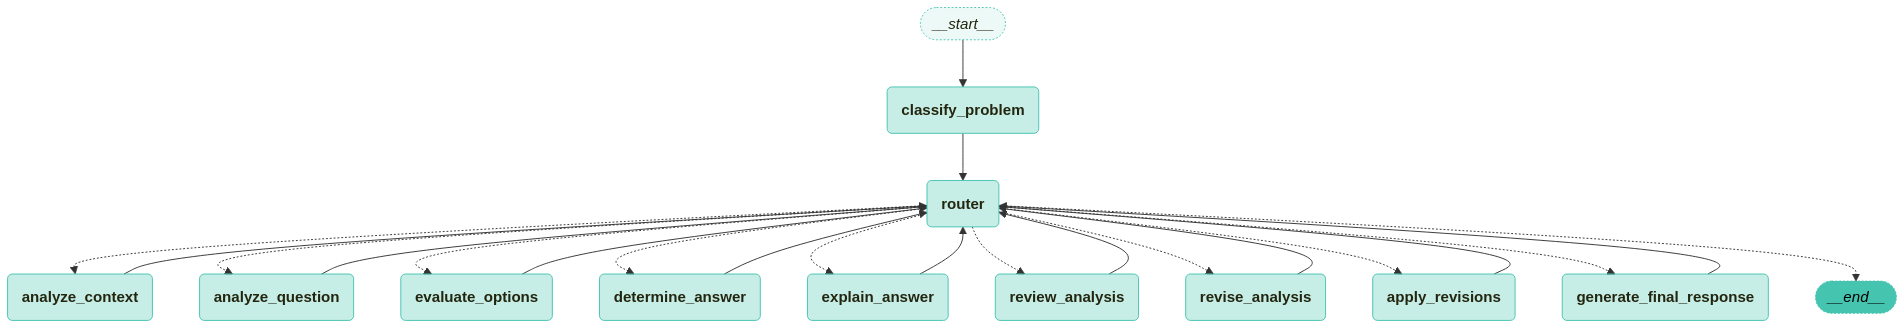

In [56]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.checkpoint.memory import MemorySaver
# 메모리 저장소 초기화
memory = MemorySaver()

visualize_graph(app)



In [57]:
import pandas as pd

json_data = pd.read_json('./data/2023_11_KICE.json')
print(len(json_data))
json_data.head()
json_data.info()

11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         11 non-null     object
 1   paragraph  11 non-null     object
 2   type       11 non-null     int64 
 3   problems   11 non-null     object
dtypes: int64(1), object(3)
memory usage: 484.0+ bytes


In [58]:
from dataclasses import dataclass, field
from typing import List, Optional, Dict, Any
import json

@dataclass
class Problem:
    question: str
    choices: List[str]
    answer: int
    score: int
    paragraph: Optional[str] = None
    question_plus: str = ""
    number: Optional[int] = None
    
    # 클래스 변수
    _number_counter: int = field(default=0, init=False, repr=False)
    
    def __post_init__(self):
        # number가 지정되지 않은 경우 자동 부여
        if self.number is None:
            type(self)._number_counter += 1
            self.number = type(self)._number_counter
    
    def predict(self, label: int) -> int:
        """모델 예측이 정답인지 평가하고 점수 반환"""
        return self.score if int(label) == int(self.answer) else 0
    
    def to_json(self) -> str:
        """문제 객체를 JSON 문자열로 변환"""
        problem_dict = {
            "number": self.number,
            "paragraph": self.paragraph,
            "question_plus": self.question_plus,
            "question": self.question,
            "choices": self.choices,
            "answer": self.answer,
            "score": self.score
        }
        return json.dumps(problem_dict, ensure_ascii=False, indent=4)
    
    def __str__(self) -> str:
        return self.question

@dataclass
class Paragraph:
    id: str
    paragraph: str
    type: str
    problems: List[Problem] = field(default_factory=list)
    
    def __post_init__(self):
        # problems 필드가 raw 데이터인 경우 파싱
        if self.problems and isinstance(self.problems, list) and self.problems and not isinstance(self.problems[0], Problem):
            self._parse_problems(self.problems)
    
    def _parse_problems(self, data_list: List[Dict[str, Any]]) -> None:
        """문제 데이터 리스트를 Problem 객체 리스트로 변환"""
        self.problems = []
        for data in data_list:
            problem = Problem(
                question=data['question'],
                choices=data['choices'],
                answer=data['answer'],
                score=data['score'],
                paragraph=data.get('paragraph', self.paragraph),
                question_plus=data.get('question_plus', ''),
                number=data.get('number')
            )
            self.problems.append(problem)
    
    def __str__(self) -> str:
        lines = f'Paragraph({self.id}): type({self.type})'
        for problem in self.problems:
            lines += f'\n\t- {problem.number}) {problem}'
        return lines

# problem_list 생성 예시
def create_problem_list(json_data):
    problem_list : List[Problem]= [] 
    
    for i in range(len(json_data)):
        paragraph_data = json_data.iloc[i]
        paragraph = Paragraph(
            id=paragraph_data['id'],
            paragraph=paragraph_data['paragraph'],
            type=paragraph_data['type'],
            problems=paragraph_data['problems']
        )
        problem_list.extend(paragraph.problems)
    
    return problem_list


problem_list = create_problem_list(json_data)
print(problem_list[1])
print(problem_list[1].answer)

다음은 학생이 독서 후 작성한 글의 일부이다. [A]를 바탕으로 ⓐ～ⓔ를 이해한 내용으로 가장 적절한 것은?
5


In [59]:



# 문제 번호
print(problem_list[0].number)

# 지문
print(problem_list[0].paragraph)

# 선택지
print(problem_list[0].choices)

# 문제
print(problem_list[0].question)

# 문제 추가 설명
print(problem_list[0].question_plus)
# 정답
print(problem_list[0].answer)


#점수
print(problem_list[0].score)

1
사람들이 지속적으로 책을 읽는 이유 중 하나는 즐거움이다. 독서의 즐거움에는 여러 가지가 있겠지만 그 중심에는 ‘소통의 즐거움’이 있다.독자는 독서를 통해 책과 소통하는 즐거움을 경험한다. 독서는필자와 간접적으로 대화하는 소통 행위이다. 독자는 자신이 속한사회나 시대의 영향 아래 필자가 속해 있거나 드러내고자 하는 사회나 시대를 경험한다. 직접 경험하지 못했던 다양한 삶을 필자를 매개로 만나고 이해하면서 독자는 더 넓은 시야로 세계를바라볼 수 있다. 이때 같은 책을 읽은 독자라도 독자의 배경지식이나 관점 등의 독자 요인, 읽기 환경이나 과제 등의 상황 요인이 다르므로, 필자가 보여 주는 세계를 그대로 수용하지 않고 저마다 소통 과정에서 다른 의미를 구성할 수 있다.[A] (이러한 소통은 독자가 책의 내용에 대해 질문하고 답을 찾아내는 과정에서 가능해진다. 독자는 책에서 답을 찾는 질문, 독자 자신에게서 답을 찾는 질문 등을 제기할 수 있다. 전자의 경우 책에 명시된 내용에서 답을 발견할 수 있고, 책의 내용들을 관계 지으며 답에 해당하는 내용을 스스로 구성할 수도 있다. 또한 후자의 경우 책에는 없는 독자의 경험에서 답을 찾을 수 있다. 이런 질문들을 풍부히 생성하고 주체적으로 답을 찾을 때 소통의 즐거움은 더 커진다.)한편 독자는 ㉠ (다른 독자와 소통하는 즐거움을 경험할 수도 있다.) 책과의 소통을 통해 개인적으로 형성한 의미를 독서 모임이나 독서 동아리 등에서 다른 독자들과 나누는 일이 이에 해당한다. 비슷한 해석에 서로 공감하며 기존 인식을 강화하거나 관점의 차이를 확인하고 기존 인식을 조정하는 과정에서, 독자는자신의 인식을 심화 확장할 수 있다. 최근 소통 공간이 온라인으로 확대되면서 독서를 통해 다른 독자들과 소통하며 즐거움을누리는 양상이 더 다양해지고 있다. 자신의 독서 경험을 담은 글이나 동영상을 생산 공유함으로써, 책을 읽지 않은 타인이 책과 소통하도록 돕는 것도 책을 통한 소통의 즐거움을 나누는 일이다.
['같은 책을 읽은 독자라도 서로 

In [60]:
def predict():
    

SyntaxError: incomplete input (1027369206.py, line 2)